In [1]:
import numpy as np
import pandas as pd
import scipy.io
import cPickle as pickle
import gzip

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data = scipy.io.loadmat('data/train_32x32.mat', variable_names='X').get('X')
train_labels = scipy.io.loadmat('data/train_32x32.mat', variable_names='y').get('y')
test_data = scipy.io.loadmat('data/test_32x32.mat', variable_names='X').get('X')
test_labels = scipy.io.loadmat('data/test_32x32.mat', variable_names='y').get('y')
extra_data = scipy.io.loadmat('data/extra_32x32.mat', variable_names='X').get('X')
extra_labels = scipy.io.loadmat('data/extra_32x32.mat', variable_names='y').get('y')

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(extra_data.shape, extra_labels.shape)

train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0
extra_labels[extra_labels == 10] = 0

train_data = np.concatenate((extra_data, train_data), axis=3).transpose((3,0,1,2))
train_labels = np.concatenate((extra_labels, train_labels), axis=0)[:,0]

test_data = test_data.transpose((3,0,1,2))
test_labels = test_labels[:,0]

extra_data = None
extra_labels = None

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

((32, 32, 3, 73257), (73257, 1))
((32, 32, 3, 26032), (26032, 1))
((32, 32, 3, 531131), (531131, 1))
((604388, 32, 32, 3), (604388,))
((26032, 32, 32, 3), (26032,))


In [ ]:
df = pd.DataFrame(train_labels)
df[0].value_counts().plot(kind="bar")

In [ ]:
df = pd.DataFrame(test_labels)
df[0].value_counts().plot(kind="bar")

In [6]:
def dense_to_one_hot(labels_dense, num_classes=10):
  """Convert class labels from scalars to one-hot vectors."""
  num_labels = labels_dense.shape[0]
  index_offset = np.arange(num_labels) * num_classes
  labels_one_hot = np.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot

In [ ]:
data = {"train_data": train_data, 
        "train_labels": dense_to_one_hot(train_labels),
        "test_data": test_data, 
        "test_labels": dense_to_one_hot(test_labels)
       }
with gzip.open("data/svhn_full_color_norm.pkl", "wb") as f:
  pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)


In [3]:
# Using Method from: http://www.eyemaginary.com/Rendering/TurnColorsGray.pdf
# Fast, contrast enhancing grayscale conversion
def rbg2gray(img):
    img = img.astype(float)
    return np.dot(img, [[0.2989],[0.5870],[0.1140]])

# Global Contrast Normalization
# As per: https://github.com/hangyao/street_view_house_numbers/blob/master/1_preprocess_single.ipynb
def GCN(image, min_divisor=1e-4):
    imsize = image.shape[0]
    mean = np.mean(image, axis=(1,2), dtype=float)
    std = np.std(image, axis=(1,2), dtype=float, ddof=1)
    std[std < min_divisor] = 1.
    image_GCN = np.zeros(image.shape, dtype=float)
    
    for i in np.arange(imsize):
        image_GCN[i,:,:] = (image[i,:,:] - mean[i]) / std[i]
        
    return image_GCN
  
train_data_gray = rbg2gray(train_data)[:,:,:,0]
test_data_gray = rbg2gray(test_data)[:,:,:,0]

train_data_gcn = GCN(train_data_gray)
test_data_gcn = GCN(test_data_gray)

print(train_data_gcn.shape, train_labels.shape)
print(test_data_gcn.shape, test_labels.shape)

((604388, 32, 32), (604388,))
((26032, 32, 32), (26032,))


In [7]:
data = {
         "train_labels": dense_to_one_hot(train_labels),
         "test_data": test_data_gcn, 
         "test_labels": dense_to_one_hot(test_labels)
       }

with gzip.open("data/svhn_grayscale_gcn.pkl", "wb") as f:
  pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [4]:
np.save("data/svhn_grayscale_gcn_train.np", train_data_gcn)

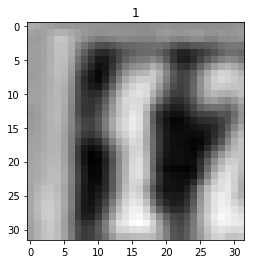

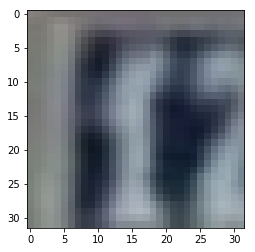

In [23]:
for i in range(15, 16):
  fig = plt.figure()
  ax = fig.add_subplot(1,1,1)
  lbl = train_labels[i]
  ax.set_title(lbl)

  img_gcn = train_data_gcn[i]
  plt.imshow(img_gcn, cmap="gray"); plt.show()
  
  img_org = train_data[i]
  plt.imshow(img_org); plt.show()

In [ ]:
# for i in range(1010, 1014):
#   fig = plt.figure()
#   ax = fig.add_subplot(1,1,1)
#   img_255_label = train_labels_full[i]
#   ax.set_title(img_255_label)

#   img_255 = train_data_full[i]
#   plt.imshow(img_255); plt.show()
#   img_255 = im2gray(img_255)#
#   plt.imshow(img_255[:, :, 0]); plt.show()
#   img_255 = GCN(img_255)
#   plt.imshow(img_255[:,:,0]); plt.show()

#   img_01 = GCN(data_sets.train.images[i])
#   img_01_label = data_sets.train.labels[i]
#   imgplot = plt.imshow(img_01)
#   plt.show()